# Function Tests

This notebook tests `countmatch_common.py`, `countmatch_teps.py` and `countmatch_bagheri.py`.

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import importlib
import matplotlib.pyplot as plt
import numpy as np
import knowyourdata as kyd

import pandas as pd
from traffic_prophet import cfg
import pathlib, os
import configparser

from traffic_prophet import connection
from traffic_prophet.countmatch import reader
from traffic_prophet.countmatch import growthfactor as gf
from traffic_prophet.countmatch import neighbour

defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

filepath = pathlib.Path.home().joinpath('.charlesconfig')
if os.path.isfile(filepath):
    vol_conn = connection.Connection(filepath, 'POSTGRES',
                                     'czhu.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'POSTGRES',
                                    'czhu.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['MAPBOX']['token']
    PLOTLY_USER = config['PLOTLY']['user']
    PLOTLY_KEY = config['PLOTLY']['key']
else:
    filepath = pathlib.Path.home().joinpath('cf.txt')
    vol_conn = connection.Connection(filepath, 'localpg',
                                     'prj_vol.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'localpg',
                                    'gis.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['mapbox']['token']
    PLOTLY_USER = config['plotly']['user']
    PLOTLY_KEY = config['plotly']['apikey']

In [2]:
%%time
rdr_teps = reader.Reader(vol_conn)
rdr_teps.read()
gf.get_growth_factors(rdr_teps)

CPU times: user 1min 36s, sys: 684 ms, total: 1min 37s
Wall time: 1min 38s


In [3]:
ptc_ids = np.unique(np.abs(list(rdr_teps.ptcs.keys())))
nb = neighbour.NeighbourLonLatEuclidean(ll_conn, 20, ptc_ids)
%time nb.find_neighbours()

CPU times: user 18.3 s, sys: 213 ms, total: 18.5 s
Wall time: 18.3 s


In [4]:
%%time
rdr_bag = reader.Reader(vol_conn)
rdr_bag.read()
gf.get_growth_factors(rdr_bag)

CPU times: user 1min 36s, sys: 178 ms, total: 1min 36s
Wall time: 1min 37s


## TEPs-like CountMatch

Testing the `countmatch_teps` module.

In [5]:
import countmatch_teps as cmt
importlib.reload(cmt)

<module 'countmatch_teps' from '/home/cczhu/GitHub/bdit_traffic_prophet/development_notebooks/countmatch_teps.py'>

In [6]:
teps_aadt_estimates = cmt.estimate_aadts(
    rdr_teps, nb, 2019, n_neighbours=5, single_direction=True, progress_bar=True)

In [7]:
import countmatch_common as cmc
importlib.reload(cmc)

<module 'countmatch_common' from '/home/cczhu/GitHub/bdit_traffic_prophet/development_notebooks/countmatch_common.py'>

In [8]:
ptc_estimates = cmc.aadt_estimator_for_ptcs(rdr_teps, 2019, override_growth_factor=False)

In [9]:
teps_aadt_estimates = cmc.combine_estimators(teps_aadt_estimates, ptc_estimates)

In [10]:
teps_aadt_estimates

,Count ID,PTC ID,Closest Year,D_ij,AADT Estimate_STTC,AADT Estimate_PTC,AADT Estimate
0,-175,-445884,2010,0.976424,2208.113549,NaN,2208.113549
1,175,446012,2010,0.915809,1818.715350,NaN,1818.715350
2,-201,-443987,2006,0.937714,339.977238,NaN,339.977238
3,201,445280,2006,0.984605,267.842517,NaN,267.842517
4,-202,-443975,2006,0.980700,213.250136,NaN,213.250136
...,...,...,...,...,...,...,...
15548,-30078909,-9313402,2018,0.961568,18012.583347,NaN,18012.583347
15549,30078909,5849817,2018,0.971144,18532.489161,NaN,18532.489161
15550,-30078912,-8171,2018,0.957668,17780.922533,NaN,17780.922533
15551,-30085792,-441170,2018,0.999262,6110.968458,NaN,6110.968458


## Hybrid Count Module

Testing `countmatch_hybrid.py`.

In [11]:
import countmatch_hybrid as cmh
importlib.reload(cmh)

<module 'countmatch_hybrid' from '/home/cczhu/GitHub/bdit_traffic_prophet/development_notebooks/countmatch_hybrid.py'>

In [12]:
bag_aadt_estimates = cmh.estimate_aadts(rdr_bag, nb, 2019, progress_bar=True)

In [13]:
bag_aadt_estimates.head()

,Count ID,Nearest PTCS,Errors,PTC ID,Growth Factor,Most Recent Year,AADT Estimate
0,-175,"[-1022, -444637, -890, -445309, -445884]","[0.5608327532405594, 0.8307061415303842, 0.634...",-1022,1.135230,2010,5378.846957
1,175,"[446012, 1033, 444516, 1003, 444782]","[0.48182483033236795, 0.4179452872922771, 0.20...",444516,1.271847,2010,12889.208626
2,-201,"[-445309, -445884, -444637, -443975, -443987]","[0.0029596013716408163, 0.0, 0.001936558982980...",-445884,0.909007,2006,74.947454
3,201,"[445280, 444782, 444403, 444516, 446012]","[0.000271132236083406, 0.0, 0.0, 0.0, 7.335767...",444782,0.984669,2006,157.838043
4,-202,"[-445309, -445884, -444637, -443975, -443987]","[1.0984804229158482e-05, 0.0, 0.00291553627916...",-445884,0.909007,2006,49.870941


In [14]:
bag_aadt_estimates = cmc.combine_estimators(bag_aadt_estimates, ptc_estimates)

In [15]:
bag_aadt_estimates

,Count ID,Nearest PTCS,Errors,PTC ID,Growth Factor,Most Recent Year,AADT Estimate_STTC,AADT Estimate_PTC,AADT Estimate
0,-175,"[-1022, -444637, -890, -445309, -445884]","[0.5608327532405594, 0.8307061415303842, 0.634...",-1022,1.135230,2010,5378.846957,NaN,5378.846957
1,175,"[446012, 1033, 444516, 1003, 444782]","[0.48182483033236795, 0.4179452872922771, 0.20...",444516,1.271847,2010,12889.208626,NaN,12889.208626
2,-201,"[-445309, -445884, -444637, -443975, -443987]","[0.0029596013716408163, 0.0, 0.001936558982980...",-445884,0.909007,2006,74.947454,NaN,74.947454
3,201,"[445280, 444782, 444403, 444516, 446012]","[0.000271132236083406, 0.0, 0.0, 0.0, 7.335767...",444782,0.984669,2006,157.838043,NaN,157.838043
4,-202,"[-445309, -445884, -444637, -443975, -443987]","[1.0984804229158482e-05, 0.0, 0.00291553627916...",-445884,0.909007,2006,49.870941,NaN,49.870941
...,...,...,...,...,...,...,...,...,...
15548,-30078909,"[-442161, -13503206, -13503207, -13503251, -93...","[0.0, 0.0, 0.0, 0.0, 0.0]",-442161,0.983852,2018,15844.016499,NaN,15844.016499
15549,30078909,"[6248089, 20230203, 14065128, 438481, 5849817]","[0.0, 0.0, 0.0, 0.0, 0.0]",6248089,0.907765,2018,14136.934913,NaN,14136.934913
15550,-30078912,"[-442161, -13503206, -13503207, -13503251, -8171]","[0.0, 0.0, 0.0, 0.0, 0.0]",-442161,0.983852,2018,15703.874305,NaN,15703.874305
15551,-30085792,"[-441170, -440171, -440332, -20140757, -442447]","[0.0020327721096051556, 0.0009564263148283921,...",-440332,1.128996,2018,7427.540302,NaN,7427.540302


## Bagheri Count Module

Lastly, we test `countmatch_bagheri.py`, which most closely resembles Bagheri et al.

In [105]:
import countmatch_bagheri as cmb
importlib.reload(cmb)

<module 'countmatch_bagheri' from '/home/cczhu/GitHub/bdit_traffic_prophet/development_notebooks/countmatch_bagheri.py'>

In [26]:
# Process nearest PTC comparisons to estimate AADT for each STTC.
cmb.get_aadt_estimate_for_sttc(
    rdr_bag.sttcs[-104968], rdr_bag.ptcs, nb, 2019, cmb.estimate_mse)

(-104968,
 [-9637988, -20050591, -106797, -440171, -440332],
 [0.020311053152507787,
  0.16096539450106656,
  0.03363498407145927,
  0.024162129286363795,
  0.033208897282334233],
 -9637988,
 1.0912579689144433,
 2011,
 9484.326885922374)

In [27]:
cmh.get_aadt_estimate_for_sttc(
    rdr_bag.sttcs[-104968], rdr_bag.ptcs, nb, 2019)

(-104968,
 [-9637988, -20050591, -106797, -440171, -440332],
 [0.020311053152507787,
  0.03446119685626187,
  0.014340427965565766,
  0.025477312658990885,
  0.08086985242295579],
 -106797,
 0.9822227851855124,
 2011,
 3290.318451424282)

In [31]:
ptc_match = cmh.get_ptc_match(rdr_bag.sttcs[-104968], rdr_bag.ptcs[-9637988])
# mses.append((ptc.count_id,) +
#             estimate_mse(ptc_match, ptc, want_year,
#                          ptc.growth_factor))

In [32]:
ptc_match

,Year,Date,Daily Count,Day of Week,Month,Closest Year,D_ijd,DoM_ijd
0,2006,2006-03-21,3811.0,1,3,2010,1.108422,0.990201
1,2006,2006-03-22,3817.0,2,3,2010,1.109234,0.990926
2,2006,2006-03-23,4001.0,3,3,2010,1.074876,0.960233
3,2011,2011-12-13,4083.0,1,12,2010,1.192009,0.991644
4,2011,2011-12-14,4037.0,2,12,2010,1.128942,0.939178
5,2011,2011-12-15,4228.0,3,12,2010,1.117295,0.929489


In [33]:
gf_0 = rdr_bag.ptcs[-9637988].growth_factor
ptc_match['MADT_est'] = (
    ptc_match['Daily Count'] * ptc_match['DoM_ijd'] *
    gf_0**(want_year - ptc_match['Year']))
madt_est = pd.DataFrame(
    {'MADT_estimate': ptc_match.groupby('Month')['MADT_est'].mean()})
madt_est['AADT_est'] = (
    ptc_match['Daily Count'] * ptc_match['D_ijd'] *
    gf_0**(want_year - ptc_match['Year'])).mean()
madt_est['MF_STTC'] = madt_est['MADT_estimate'] / madt_est['AADT_est']

In [48]:
def check_errs(madt_est, ptc):
    madt_est = madt_est[['MF_STTC']].copy()
    
    ptc_closest_year = cmc.get_closest_year(
        want_year, ptc.data['AADT'].index.values)
    
    madt_est['MF_PTC'] = (
        ptc.data['MADT'].loc[ptc_closest_year, 'MADT'] /
        ptc.data['AADT'].loc[ptc_closest_year, 'AADT'])

    return madt_est, ((madt_est['MF_PTC'] - madt_est['MF_STTC'])**2).mean()

In [49]:
check_errs(madt_est, rdr_bag.ptcs[-9637988])

(        MF_STTC    MF_PTC
 Month                    
 3      1.040841  0.893343
 12     0.694555  0.831910, 0.020311053152507787)

In [50]:
check_errs(madt_est, rdr_bag.ptcs[-440171])

(        MF_STTC    MF_PTC
 Month                    
 3      1.040841  0.955234
 12     0.694555  0.897029, 0.024162129286363795)

In [54]:
pcy = ptc_match[ptc_match['Year'] == 2011]
(pcy['Daily Count'] * pcy['D_ijd'] * gf_0**(2019 - 2011)).mean()

9484.326885922374

In [58]:
# Try another station.
cmb.get_aadt_estimate_for_sttc(
    rdr_bag.sttcs[-908441], rdr_bag.ptcs, nb, 2019, cmb.estimate_mse)

(-908441,
 [-8171, -30073761, -913864, -442161, -13503206],
 [0.15338537614879347,
  0.1435236370456765,
  0.16675608363212505,
  0.12974244938560087,
  0.10613770084456559],
 -13503206,
 1.1814646760798009,
 2011,
 4612.122254189972)

In [63]:
ptc_match = cmh.get_ptc_match(rdr_bag.sttcs[-908441], rdr_bag.ptcs[-13503206])
pcy = ptc_match[ptc_match['Year'] == 2011]
(pcy['Daily Count'] * pcy['D_ijd'] * rdr_bag.ptcs[-13503206].growth_factor**(2019 - 2011)).mean()

4612.122254189972

In [65]:
cmb.get_aadt_estimate_for_sttc(
    rdr_bag.sttcs[-908441], rdr_bag.ptcs, nb, 2019, cmb.estimate_mse,
    override_growth_factor=1.02)

(-908441,
 [-8171, -30073761, -913864, -442161, -13503206],
 [0.11824199985170866,
  0.10960624759090282,
  0.1300182855127415,
  0.09764434322712333,
  0.07732405245706288],
 -13503206,
 1.02,
 2011,
 1423.4304539230598)

In [64]:
cmb.get_aadt_estimate_for_sttc(
    rdr_bag.sttcs[-908441], rdr_bag.ptcs, nb, 2019, cmb.estimate_cov)

(-908441,
 [-8171, -30073761, -913864, -442161, -13503206],
 [0.6405047437206526,
  0.6271811053764351,
  0.6576714032943388,
  0.5991368399171806,
  0.5580172429346411],
 -13503206,
 1.1814646760798009,
 2011,
 4612.122254189972)

In [94]:
ptc_match, madt_est = cmb.get_madt_estimate(
    rdr_bag.sttcs[-908441], rdr_bag.ptcs[-8171],
    2019, rdr_bag.ptcs[-8171].growth_factor)

In [95]:
madt_est

,MADT_estimate,AADT_est
Month,,
3,6591.114631,5184.441986
12,2286.459510,5184.441986


In [96]:
ptc_madt = rdr_bag.ptcs[-13503206].data['MADT'].loc[2017] * rdr_bag.ptcs[-13503206].growth_factor**(2019-2017)

In [97]:
madt_ratio = madt_est['MADT_estimate'] / ptc_madt.loc[[3,12], 'MADT']

In [98]:
madt_ratio.std() / madt_ratio.mean()

0.5580172429346411

In [99]:
cmb.estimate_cov(madt_est, rdr_bag.ptcs[-13503206], 2019)

0.5580172429346411

In [100]:
cmb.estimate_cov(madt_est, rdr_bag.ptcs[-30073761], 2019)

0.6271811053764351

In [102]:
cmb.get_aadt_estimate_for_sttc(
    rdr_bag.sttcs[-908441], rdr_bag.ptcs, nb, 2019, cmb.estimate_cov,
    override_growth_factor=1.02)

(-908441,
 [-8171, -30073761, -913864, -442161, -13503206],
 [0.5521919197020481,
  0.5379960199872635,
  0.5705134420839497,
  0.5081842833779652,
  0.46464032941234384],
 -13503206,
 1.02,
 2011,
 1423.4304539230598)

In [106]:
bagcov_aadt_estimates = cmb.estimate_aadts(rdr_bag, nb, 2019, erroralgo='Minimum COV', progress_bar=True)

In [107]:
bagcov_aadt_estimates

,Count ID,Nearest PTCS,Errors,PTC ID,Growth Factor,Most Recent Year,AADT Estimate
0,-175,"[-1022, -444637, -890, -445309, -445884]","[1.029602977206374, 1.0784675337436187, 1.0590...",-445884,0.909007,2010,709.179372
1,175,"[446012, 1033, 444516, 1003, 444782]","[0.9219096960080154, 1.002837457010231, 1.0273...",446012,1.013699,2010,1273.026124
2,-201,"[-445309, -445884, -444637, -443975, -443987]","[0.0, 0.0, 0.0, 0.0, 0.0]",-445309,0.993865,2006,238.796524
3,201,"[445280, 444782, 444403, 444516, 446012]","[0.0, 0.0, 0.0, 0.0, 0.0]",445280,0.997773,2006,187.826976
4,-202,"[-445309, -445884, -444637, -443975, -443987]","[0.0, 0.0, 0.0, 0.0, 0.0]",-445309,0.993865,2006,142.003923
...,...,...,...,...,...,...,...
15548,-30078909,"[-442161, -13503206, -13503207, -13503251, -93...","[0.0, 0.0, 0.0, 0.0, 0.0]",-442161,0.983852,2018,15844.016499
15549,30078909,"[6248089, 20230203, 14065128, 438481, 5849817]","[0.0, 0.0, 0.0, 0.0, 0.0]",6248089,0.907765,2018,14136.934913
15550,-30078912,"[-442161, -13503206, -13503207, -13503251, -8171]","[0.0, 0.0, 0.0, 0.0, 0.0]",-442161,0.983852,2018,15703.874305
15551,-30085792,"[-441170, -440171, -440332, -20140757, -442447]","[0.0607338094176366, 0.055597029748640996, 0.0...",-440332,1.128996,2018,7427.540302


In [114]:
aadt_est_check = pd.merge(bag_aadt_estimates[['AADT Estimate']], bagcov_aadt_estimates[['AADT Estimate']],
                          how='outer', left_index=True, right_index=True)

In [118]:
aadt_est_check['Fractional Error'] = (2 * abs(aadt_est_check['AADT Estimate_x'] - aadt_est_check['AADT Estimate_y']) /
                                      (aadt_est_check['AADT Estimate_x'] + aadt_est_check['AADT Estimate_y']))

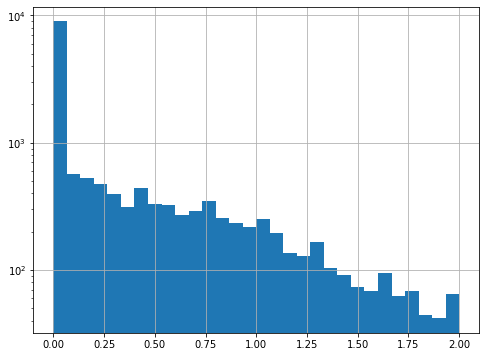

In [121]:
fig, ax = plt.subplots(figsize=(8, 6))
aadt_est_check['Fractional Error'].hist(ax=ax, bins=30, log=True)

## Note: -175 is a terrible STTC

In [19]:
tc = rdr_bag.sttcs[-175]
ptcs = rdr_bag.ptcs
want_year = 2019
n_neighbours=5
single_direction=True,

# Find nearest neighbours in same direction.
neighbour_ptcs = cmc.get_neighbours(
    tc, ptcs, nb, n_neighbours=n_neighbours,
    single_direction=single_direction)

# Determine minimum MSE tables for closest neighbouring PTCs.
mses = []
for ptc in neighbour_ptcs:
    ptc_match = cmh.get_ptc_match(tc, ptc)
    # growth_factor = (override_growth_factor if override_growth_factor
    #                  else ptc.growth_factor)
    mses.append((ptc.count_id,) +
                cmh.estimate_mse(ptc_match, ptc, want_year,
                             cmc.get_citywide_growth_factor(rdr_bag)))
# Retrieve `ptc_match` table of minimum MSE PTC.
min_countid, mmse_ptc_match = min(mses, key=lambda x: x[-1])[0:2]

In [20]:
mses[0][1]

,Year,Date,Daily Count,Day of Week,Month,Closest Year,D_ijd,DoM_ijd,MADT_est
0,2006,2006-08-15,171.0,1,8,2016,0.951817,0.968189,220.411747
1,2010,2010-06-09,1855.0,2,6,2016,0.925953,0.962942,2177.623663


In [21]:
mses[1][1]

,Year,Date,Daily Count,Day of Week,Month,Closest Year,D_ijd,DoM_ijd,MADT_est
0,2006,2006-08-15,171.0,1,8,2010,0.975602,1.005890,228.994586
1,2010,2010-06-09,1855.0,2,6,2010,0.991796,0.984848,2227.162266


In [22]:
# Process nearest PTC comparisons to estimate AADT for each STTC.
cmb.get_aadt_estimate_for_sttc(
    rdr_bag.sttcs[-175], rdr_bag.ptcs, nb, 2019, cmb.estimate_mse,
    override_growth_factor=cmc.get_citywide_growth_factor(rdr_bag))

(-175,
 [-1022, -444637, -890, -445309, -445884],
 [0.6984172544782186,
  0.8374002130428739,
  0.7795400789582994,
  0.69686364325305,
  0.5902844916985741],
 -445884,
 1.0222564979935564,
 2010,
 2040.2871790117917)